## Imports

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt

import numpy as np
# from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())

%matplotlib inline

/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data (of a single time slice)

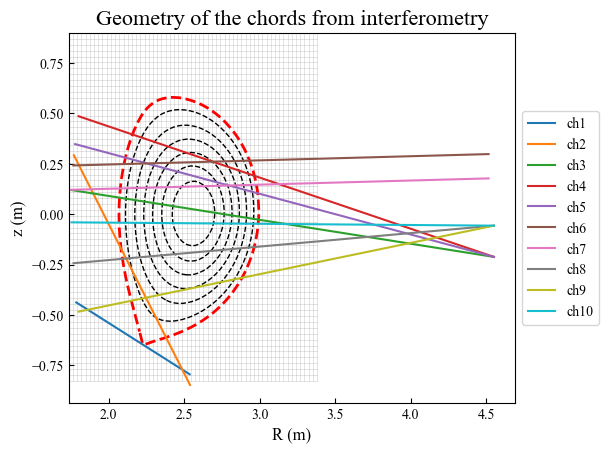

In [3]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Validation of the forward model

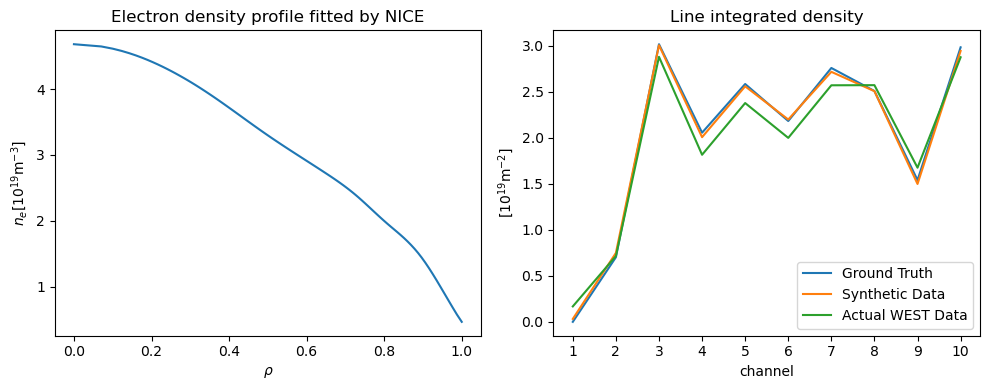

In [4]:
EXP_ER = 0.03 #background noise order of magnitude
    
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data

                                           
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='Ground Truth')
ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')
ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()

# Static Kernel



Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 2.43e-08
The Determinent of cov_post3 is: 0.0


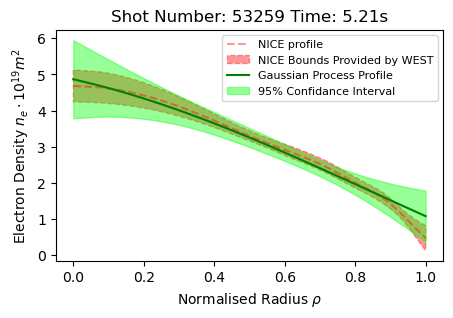

In [5]:
lid_d = lid_data
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))
##Prior
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
mu_prior = np.zeros(N)
#exponential square kernel
def Kernel(rho1,rho2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((rho1-rho2)*(rho1-rho2))/(2*l**2))

def KRcov_li(params,trial_EXP_ER):
    rho1, rho2 = np.meshgrid(rho_1d,rho_1d)
    #covergence matrix of Prior
    K = Kernel(rho1,rho2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_EXP_ER,10))
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,EXP_ER)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(lid_d.T@chol_inv(cov_li+R@K@R.T)@lid_d)                
    
# x0=[0.76,0.1]

x0=[5.62,1.37]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=50)
# print(results)
# best_params = results.x
best_params = x0

def PlotBest(params,trial_EXP_ER): 
    K, R, cov_li = KRcov_li(params,trial_EXP_ER)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_d - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    plt.legend(fontsize = 8)
    plt.show()

PlotBest(best_params, EXP_ER)

# Dynamic Kernel
The $\sigma$ and $l$ are not fixed for each $\rho$ but are tuned.

In [34]:
import scipy
lid_d = lid_data
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))
##Prior
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
mu_prior = np.zeros(N)
#exponential square kernel
def NonStatLengthScaleKernel(rho_1d,params):
    RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = np.array(params[1:])
    LA, LB = np.meshgrid(l,l)
    mag = (RHOA - RHOB) * (RHOA - RHOB)
    scale1 = 2 * LA * LB
    scale2 = LA * LA + LB * LB
    frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))
    if frac.any() < 0 or (scale1/scale2).any() == np.inf or (scale1/scale2).any() == np.nan:
        print('probs nan:\n')
        print('scale1',scale1)
        print('scale2',scale2)
        
    return amp * scipy.sqrt(frac) * np.exp(-(mag/scale2))

def KRcov_li(params,trial_EXP_ER):
    #covergence matrix of Prior
    K = NonStatLengthScaleKernel(rho_1d,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_EXP_ER,10))
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,EXP_ER)
    invertable = cov_li + R @ K @ R.T
#     print(invertable)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8
    return 0.5*np.log(chol_det(invertable)) + 0.5*(lid_d.T@chol_inv(invertable)@lid_d)                
    
# x0=[0.76,0.1]

x0=[5.62]+list(np.repeat(1.37,len(rho_1d)))
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=50)
print(results)
# best_params = results.x
# best_params = x0
# MargLi(x0)

def PlotBest(params,trial_EXP_ER): 
    K, R, cov_li = KRcov_li(params,trial_EXP_ER)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_d - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    plt.legend(fontsize = 8)
    plt.show()

# PlotBest(best_params, EXP_ER)

/tmp/ipykernel_4237/3826483482.py:30: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  return amp * scipy.sqrt(frac) * np.exp(-(mag/scale2))


LinAlgError: Matrix is not positive definite

In [23]:
np.array([1,2,3]).shape

(3,)

In [12]:
a = list(np.repeat(5,2)) + [6,6]
a

[5, 5, 6, 6]

In [17]:
np.sqrt(-1)

/tmp/ipykernel_4108/3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


nan

In [25]:
def NonStatLengthScaleKernel(rho_1d,params):
    RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
    #amplitude determins how far the model can go from the mean
#     amp = params[0]
#     #length scale determines smoothness, how correlated the function should be at a distance
    l = np.array(params[1:])
    LA, LB = np.meshgrid(l,l)
#     mag = (RHOA - RHOB) * (RHOA - RHOB)
    scale1 = 2 * LA * LB
    scale2 = LA * LA + LB * LB
    print(scale1)
    print(scale2)
    print((scale1/scale2)**(1/2))
#     return amp * np.sqrt(scale1/scale2) * np.exp(-(mag/scale2))

K = NonStatLengthScaleKernel(rho_1d,x0)

[[3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 ...
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]]
[[3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 ...
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
